In [3]:
from nltk.tokenize import WordPunctTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

e:\miniconda3\envs\cs224\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Raw text:

In [2]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

Build vocab:

In [3]:
tokenizer = WordPunctTokenizer()
tokens = tokenizer.tokenize(raw_text.lower())
vocab = list(set(tokens))
vocab_size = len(vocab)

Build context and target pari:

In [4]:
from pprint import pprint

context_size = 2

data = []
for token in tokens[context_size:-context_size]:  # ignore boundary tokens
    token_index = tokens.index(token)
    context = tokens[token_index - context_size: token_index] + tokens[token_index + 1: token_index + context_size + 1]
    target = token
    data.append((context, target))

print("5 random samples")
pprint(data[:5])

5 random samples
[(['we', 'are', 'to', 'study'], 'about'),
 (['are', 'about', 'study', 'the'], 'to'),
 (['about', 'to', 'the', 'idea'], 'study'),
 (['to', 'study', 'idea', 'of'], 'the'),
 (['study', 'the', 'of', 'a'], 'idea')]


Helper function to create context vector:

In [50]:

ind2word = {i:w for i, w in enumerate(vocab)}
word2ind = {w:i for i, w in enumerate(vocab)}

def make_context_vector(context, word2ind):
    idxs = [word2ind[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

make_context_vector(data[0][0], word2ind)

tensor([37, 44, 19, 39])

CBOW:

In [16]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.proj = nn.Linear(in_features=embedding_dim, out_features=128)
        self.output = nn.Linear(in_features=128, out_features=vocab_size)

    def forward(self, inputs):
        embeds = (1 / (2 * context_size) * self.embedding(inputs).sum(dim=0)).view(1, -1)
        proj = self.proj(embeds)
        out = self.output(proj)
        nll_prob = F.log_softmax(out, dim=-1)
        return nll_prob

Train model:

In [67]:
embedding_dim = 10

cbow = CBOW(vocab_size=vocab_size, embedding_dim=embedding_dim)
optimizer = torch.optim.SGD(cbow.parameters(), lr=0.001)

losses = []
loss = nn.NLLLoss()

In [68]:
epochs = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cbow.to(device)

for epoch in range(epochs):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word2ind).to(device)
        target_vector = torch.tensor([word2ind[target]], dtype=torch.long).to(device)

        nll_prob = cbow(context_vector)

        cbow.zero_grad()

        l = loss(nll_prob, target_vector)
        l.backward()
        optimizer.step()

        total_loss += l.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")
    losses.append(total_loss)

Epoch 1, Loss: 253.27525734901428
Epoch 2, Loss: 251.52425003051758
Epoch 3, Loss: 249.7962474822998
Epoch 4, Loss: 248.09078311920166
Epoch 5, Loss: 246.40746545791626
Epoch 6, Loss: 244.7459716796875
Epoch 7, Loss: 243.10603713989258
Epoch 8, Loss: 241.48746848106384
Epoch 9, Loss: 239.89012360572815
Epoch 10, Loss: 238.3139045238495
Epoch 11, Loss: 236.75876545906067
Epoch 12, Loss: 235.224684715271
Epoch 13, Loss: 233.7116768360138
Epoch 14, Loss: 232.21977424621582
Epoch 15, Loss: 230.74901366233826
Epoch 16, Loss: 229.2994315624237
Epoch 17, Loss: 227.87105751037598
Epoch 18, Loss: 226.46389985084534
Epoch 19, Loss: 225.0779379606247
Epoch 20, Loss: 223.71311128139496
Epoch 21, Loss: 222.36931705474854
Epoch 22, Loss: 221.04640233516693
Epoch 23, Loss: 219.74415981769562
Epoch 24, Loss: 218.4623212814331
Epoch 25, Loss: 217.2005672454834
Epoch 26, Loss: 215.95851504802704
Epoch 27, Loss: 214.73573327064514
Epoch 28, Loss: 213.53174781799316
Epoch 29, Loss: 212.34603118896484
Epoc

Predict:

In [69]:
context = ['we','are','to', 'study']
context_vector = make_context_vector(context, word2ind).to(device)
a = cbow(context_vector).detach().cpu().squeeze()
print(f'Raw text: {raw_text}')
print(f'Test Context: {context}')
max_idx = torch.argmax(a, axis=-1).item()
print(f'\nPrediction: {ind2word[max_idx]}')

Raw text: We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.
Test Context: ['we', 'are', 'to', 'study']

Prediction: about


Visualize embedding results:

In [70]:
embedder = cbow.embedding
sample_words = ['process', 'computer', 'data', 'program', 'people', 'we']
embedded_words = {word: embedder.weight[word2ind[word]].detach().cpu().numpy() for word in sample_words}

In [71]:
embedded_words

{'process': array([ 0.64501125, -0.4071673 ,  0.5174458 , -0.05592355, -0.14806238,
         1.6818755 , -0.35157594,  1.1424899 , -1.4515704 ,  0.22997485],
       dtype=float32),
 'computer': array([-1.6185249 ,  1.3097272 , -1.6790228 ,  0.40622348, -0.8195215 ,
        -1.286203  , -0.9047828 ,  0.24237242, -0.10927751, -0.59898895],
       dtype=float32),
 'data': array([-0.39453563, -1.306132  ,  1.5013225 , -0.78736126,  2.1178265 ,
        -0.7634887 ,  1.0542344 ,  1.649025  ,  0.38630095, -0.5839078 ],
       dtype=float32),
 'program': array([-2.4732754 ,  0.51105267, -0.373866  ,  0.48467186, -0.17955738,
         0.21877593, -0.8221533 , -0.8864248 ,  0.5289834 , -0.4929878 ],
       dtype=float32),
 'people': array([-0.2662421 ,  0.42444646,  1.2033688 , -1.4567262 ,  1.0492752 ,
         0.15062292,  0.24350879, -1.2094615 ,  0.93903244, -0.32820055],
       dtype=float32),
 'we': array([ 0.33883968, -2.3187532 ,  0.19369777,  0.783307  , -0.9726918 ,
        -0.486766  

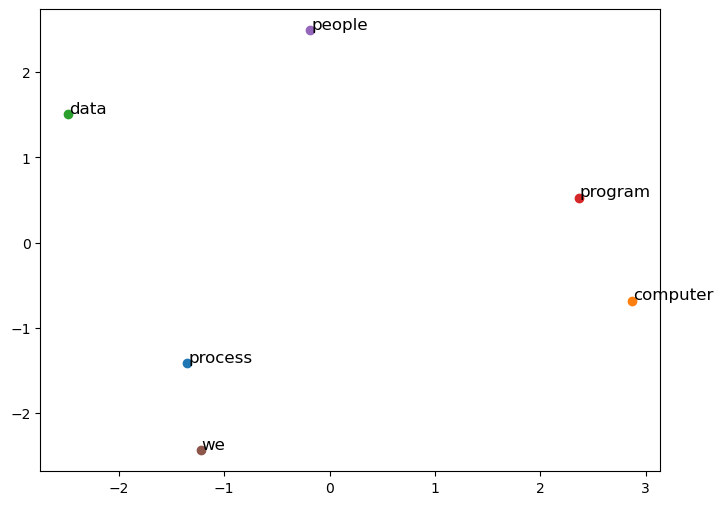

In [72]:
# visualize embeddings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(list(embedded_words.values()))
plt.figure(figsize=(8, 6))
for i, word in enumerate(sample_words):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=12)
    

CBOW on Vietnamese dataset:

In [9]:
from pprint import pprint

tokenizer = WordPunctTokenizer()

with open('datatrain.txt', 'r') as f:
    lines = f.read().splitlines()
dataset = [tokenizer.tokenize(line.lower()) for line in lines if line]
pprint(dataset[:5])

[['danh_sách', 'tác_phẩm', 'doraemon'],
 ['doraemon',
  'nguyên_tác',
  'là',
  'xê',
  'ri',
  'anime',
  'và',
  'manga',
  'được',
  'sáng_tác',
  'bởi',
  'fujiko_f'],
 ['bắt_đầu_từ',
  'những',
  'chương',
  'truyện',
  'nhỏ',
  'đăng',
  'trên',
  'tạp_chí',
  'tháng',
  'corocoro',
  'comic',
  'sau',
  'đó',
  'shogakukan',
  'tập_hợp',
  'lại',
  'phát_hành',
  'theo',
  'cuốn',
  'từ',
  'tập',
  '1',
  'đến',
  'tập',
  '45'],
 ['sau',
  'đó',
  'chuyển_thể',
  'thành',
  'anime',
  'theo',
  'ba',
  'giai_đoạn',
  'phim',
  'hoạt_hình',
  '1973',
  '1979',
  '2005',
  'và',
  '2005'],
 ['năm',
  '2014',
  'viz_media',
  'mua',
  'bản_quyền',
  'mỹ_hóa',
  'các',
  'yếu_tố',
  'trong',
  'phim',
  'như',
  'tên',
  'nhân_vật',
  'địa_điểm']]


In [10]:
# build vocab
vocab = set()
for sentence in dataset:
    for word in sentence:
        vocab.add(word)
print(f'Vocab size: {len(vocab)}')
word2ind = {w:i for i, w in enumerate(vocab)}

Vocab size: 191044


In [11]:
# build context and target pairs
context_size = 2 
datatrain = []
for sentence in dataset:
    for token in sentence[context_size:-context_size]:  # ignore boundary tokens
        token_index = sentence.index(token)
        context = sentence[token_index - context_size: token_index] + sentence[token_index + 1: token_index + context_size + 1]
        target = token
        datatrain.append((context, target))
datatrain[:5]

[(['doraemon', 'nguyên_tác', 'xê', 'ri'], 'là'),
 (['nguyên_tác', 'là', 'ri', 'anime'], 'xê'),
 (['là', 'xê', 'anime', 'và'], 'ri'),
 (['xê', 'ri', 'và', 'manga'], 'anime'),
 (['ri', 'anime', 'manga', 'được'], 'và')]

In [14]:
def make_context_vector(context, word2ind):
    idxs = [word2ind[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

print(datatrain[0])
print(make_context_vector(datatrain[0][0], word2ind), word2ind[datatrain[0][1]])

(['doraemon', 'nguyên_tác', 'xê', 'ri'], 'là')
tensor([157270,  33164, 175476,  85036]) 177843


In [17]:
# create model
embedding_dim = 300
cbow = CBOW(vocab_size=len(vocab), embedding_dim=embedding_dim)
optimizer = torch.optim.SGD(cbow.parameters(), lr=0.001)

In [18]:
loss = nn.NLLLoss()
losses = []

In [19]:
# training loops
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cbow.to(device)

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for context, target in datatrain:
        context_vector = make_context_vector(context, word2ind).to(device)
        target_vector = torch.tensor([word2ind[target]], dtype=torch.long).to(device)

        nll_prob = cbow(context_vector)

        cbow.zero_grad()

        l = loss(nll_prob, target_vector)
        l.backward()
        optimizer.step()

        total_loss += l.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")
    losses.append(total_loss)

KeyboardInterrupt: 